## 第四章 线性分类器

线性分类器的决策面是超平面，决策函数是线性函数。

有两类情况需要分开考虑：线性可分和线性不可分。

首先考虑线性可分的情况，生成数据

In [1]:
import numpy as np
import matplotlib.pyplot as plt

X是样本矩阵，每**行**是一个样本。

理论推导的样本是列向量，写代码的时候为了方便一般用行向量。

real_class是类别，分为1和-1两类。前二十个是1类，后二十个是-1类。

生成的这组数据是线性可分的。

In [2]:
X = np.r_[np.random.randn(20, 2) - [2.0, 2.0], np.random.randn(20, 2) + [2.0, 2.0]]
real_class = 20 * [1] + 20 * [-1]

print(X)
print(real_class)

[[-1.69030085  0.33211009]
 [-3.70854029 -1.98490728]
 [-0.70977456 -2.33414937]
 [-1.38645597  0.55028168]
 [-1.55520215 -2.55018627]
 [-3.1943686  -2.08674733]
 [-2.8225199  -2.37655255]
 [-2.29091509 -2.60138233]
 [-3.346072   -1.53775385]
 [-1.15295127 -2.00809166]
 [-1.897121   -2.13508493]
 [-2.4951826  -2.19290868]
 [-2.62194846 -4.02516047]
 [-0.69378579 -2.76608132]
 [-2.58471152  0.53380407]
 [-3.11573634 -3.39086032]
 [-4.17581271 -2.43940548]
 [-4.19595062 -4.10401518]
 [-1.32587364 -1.83845388]
 [-2.55570662 -1.21928456]
 [ 0.20229198  2.80454944]
 [ 0.94337597  0.49454232]
 [ 2.74705538  2.52032551]
 [ 1.49635733  3.00540679]
 [ 0.38521907  1.10112179]
 [ 3.9671367   1.84622623]
 [ 2.88935929  3.02071995]
 [ 2.17460286  0.34731256]
 [ 0.51797253  2.59836448]
 [ 1.89558346  1.14201556]
 [ 0.94694866  1.31867745]
 [ 2.445695    1.91177623]
 [ 4.01862273  3.21316744]
 [ 1.56170934  2.69958611]
 [ 0.86848116  1.08411638]
 [ 0.53759294  1.68957379]
 [ 2.62843588  1.03333909]
 

下面画的图中蓝色是-1样本，红色是1样本。

由图像可以明显看出来是线性可分的。

（这个数据是随机生成的，如果你发现你生成的是线性不可分的，就再运行几次重新生成数据，因为下面的实验必须保证线性可分）

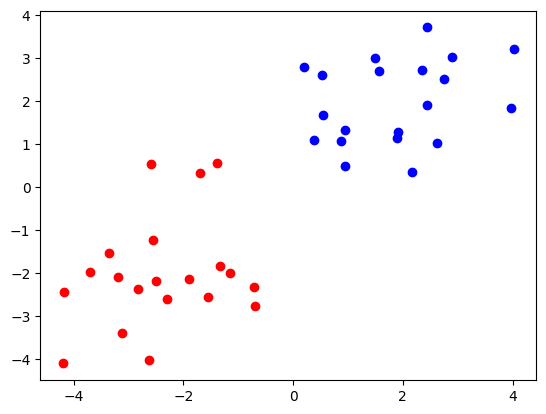

In [3]:
for i in range(40):
    if real_class[i] == -1:
        plt.scatter(X[i][0], X[i][1], c='b')
    else:
        plt.scatter(X[i][0], X[i][1], c='r')

plt.show()

### 一、Fisher线性判别

Fisher线性判别解决的是线性可分的问题。

Fisher线性判别的核心思想是投影，使投影后的样本比较好的分开。

比较好的分开是指：让投影后的每一类样本都尽可能聚集在这类的均值附近，并且不同类之间尽可能分开的远一点。

即寻找一个$\mathbf{w}$，使$y_i = \mathbf{w}^T\mathbf{x}_i$，让$y_i$尽可能好的分开。

#### 1. $\mathbf{w}$的求法：

$$
\begin{aligned}
\mathbf{m}_1 &= \frac{1}{N_1} \sum_{\mathbf{x}_i\in\mathscr{X}_1} \mathbf{x}_i \\
\mathbf{m}_2 &= \frac{1}{N_2} \sum_{\mathbf{x}_i\in\mathscr{X}_2} \mathbf{x}_i \\
\mathbf{S}_1 &= \sum_{\mathbf{x}_i\in \mathscr{X}_1}(\mathbf{x}_i-\mathbf{m}_1)(\mathbf{x}_i-\mathbf{m}_1)^T\\
\mathbf{S}_2 &= \sum_{\mathbf{x}_i\in \mathscr{X}_2}(\mathbf{x}_i-\mathbf{m}_2)(\mathbf{x}_i-\mathbf{m}_2)^T\\
\mathbf{S}_\text{w} &= \mathbf{S}_1 + \mathbf{S}_2 \\
\mathbf{w}^T &= \mathbf{S}_\text{w}^{-1}(\mathbf{m}_1 - \mathbf{m}_2)
\end{aligned}
$$

$\mathbf{m}_1$和$\mathbf{m}_2$是两类样本的均值，$\mathbf{S}_\text{w}$是pooled with-in class scatter matrix（总类内离散度矩阵，可以理解为协方差矩阵）

In [4]:
def get_mean(_X: np.ndarray) -> np.ndarray:
    """
    计算m_i（样本均值）
    :param _X: 样本矩阵，每一行是一个样本
    :return: 均值（一维向量）
    """
    return np.mean(_X, 0)


def get_within_class_scatter_matrix(_X: np.ndarray) -> np.ndarray:
    """
    计算S_i（类内离散度矩阵）
    :param _X: 样本矩阵，每一行是一个样本
    :return: 类内离散度矩阵（d * d）
    """
    ret = np.zeros((_X.shape[1], _X.shape[1]))
    m = get_mean(_X)
    print("m_i = ")
    print(m)
    for row in _X:
        ret += (row - m).reshape(m.shape[0], 1) @ (row - m).reshape(m.shape[0], 1).T
    print("S_i = ")
    print(ret)
    return ret


def get_pooled_within_class_scatter_matrix(_X1: np.ndarray, _X2: np.ndarray) -> np.ndarray:
    """
    计算S_w（总类内离散度矩阵）
    :param _X1: 第一类样本矩阵，每一行是一个样本
    :param _X2: 第二类样本矩阵，每一行是一个样本
    :return: 总类内离散度矩阵（d * d）
    """
    return get_within_class_scatter_matrix(_X1) + get_within_class_scatter_matrix(_X2)


def get_w(_X1: np.ndarray, _X2: np.ndarray) -> np.ndarray:
    """
    计算最终需要的投影方向w
    :param _X1: 第一类样本矩阵，每一行是一个样本
    :param _X2: 第二类样本矩阵，每一行是一个样本
    :return: 投影方向w（一维向量）
    """
    return np.linalg.inv(get_pooled_within_class_scatter_matrix(_X1, _X2)) @ (get_mean(_X1) - get_mean(_X2))

In [5]:
w = get_w(X[:20], X[20:])
print("w = ")
print(w)
y = X @ w
print("最终投影后的y = ")
print(y)

m_i = 
[-2.3759465  -2.00874148]
S_i = 
[[21.39953626  7.1410376 ]
 [ 7.1410376  31.43429255]]
m_i = 
[1.84673877 1.97798857]
S_i = 
[[23.90714656  5.69596571]
 [ 5.69596571 18.14627339]]
w = 
[-0.07599435 -0.06073328]
最终投影后的y = 
[ 0.10828318  0.40237804  0.1956994   0.07194241  0.27306775  0.36948898
  0.3588314   0.33208708  0.3476754   0.20957577  0.27384119  0.32280232
  0.44371446  0.22071699  0.1640038   0.44271643  0.46549127  0.56811884
  0.21241424  0.26827042 -0.18570253 -0.10172642 -0.36182832 -0.29624291
 -0.09614921 -0.41360735 -0.40303321 -0.18635096 -0.19717018 -0.21341198
 -0.15205035 -0.30196744 -0.50053882 -0.2826358  -0.1318416  -0.14346738
 -0.26250435 -0.34404915 -0.22431204 -0.41083887]


下面是投影后的图像，可以明显的看出，投影后两类样本已经很好的分开

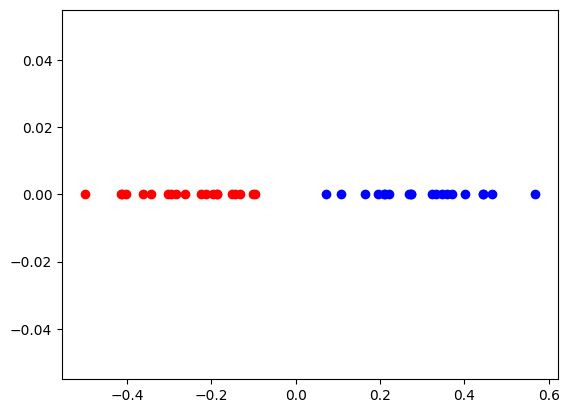

In [6]:
plt.clf()
for y_i in y[:20]:
    plt.scatter(y_i, 0, c='b')
for y_i in y[20:]:
    plt.scatter(y_i, 0, c='r')
plt.show()

#### 2. 分类

假设样本服从协方差矩阵相同的正态分布，可以得到分类规则：

$$若 g(\mathbf{x}) = \mathbf{w}^T(\mathbf{x} - \frac{1}{2}(\mathbf{m}_1 + \mathbf{m}_2)) \gtrless \ln\frac{P(\omega_2)}{P(\omega_1)}， 则 \mathbf{x}\in\begin{cases}\omega_1\\\omega_2\end{cases}$$

先验概率可以通过样本类别的数量进行估算，因为上面的样本两类数量一样，所以这里$P(\omega_1)=P(\omega_2)$

如果样本不符合正态分布，这样的分类阈值不一定为最优解，但是通常也可以取得较好效果（也就是说分界点歪了点，但是也能用）

In [7]:
def classify_Fisher(_X: np.ndarray, _w: np.ndarray, _m_1: np.ndarray, _m_2: np.ndarray) -> np.ndarray:
    """
    Fisher判别器分类
    :param _X: 样本矩阵（N * d）
    :param _w: 上面计算出来的w（投影方向）
    :param _m_1: 第一类样本均值
    :param _m_2: 第二类样本均值
    :return: 分类结果（一维向量）
    """
    g = ((_w @ (_X - 1 / 2 * (_m_1 + _m_2)).T) >= 0.0).astype(int)
    for i, g_i in enumerate(g):
        if g_i == 0:
            g[i] = -1
    return g

In [8]:
ans_Fisher = classify_Fisher(X, w, get_mean(X[:20]), get_mean(X[20:]))
print("ans_Fisher = ")
print(ans_Fisher)
print("正确率：", 1 - np.sum(abs(ans_Fisher - real_class)) / 2 / X.shape[0])

ans_Fisher = 
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
正确率： 1.0


### 二、感知器

感知器的思想是通过迭代梯度下降，找到合适的线性判别函数。如果样本是线性可分的，梯度下降最终就会收敛。

感知机解决的也是线性可分的情况。

#### 1. 预处理数据

1. 将$\mathbf{x}$增广为$\mathbf{y} = [1, \mathbf{x^T}]^T$
2. 再次处理$\mathbf{y}=\begin{cases} \mathbf{y}, &若\mathbf{y}\in \omega_1 \\ -\mathbf{y}, &若\mathbf{y}\in \omega_2\end{cases}$
3. 设权向量$\boldsymbol{\alpha}$是$d+1$维向量
4. 线性判别函数变为$g(\mathbf{y}) = \boldsymbol{\alpha}^T\mathbf{y}$
5. 可以设置余量$b$来避免噪声误差，也可以使$b=0$

预处理后感知器的核心问题就是求出权向量$\boldsymbol{\alpha}$的值，因为求出了权向量，就相当于找到了线性判别函数。

In [9]:
Y = np.concatenate((np.ones((X.shape[0], 1)), X), 1)

for i in range(20, 40):
    Y[i] = -Y[i]

print(Y)

[[ 1.         -1.69030085  0.33211009]
 [ 1.         -3.70854029 -1.98490728]
 [ 1.         -0.70977456 -2.33414937]
 [ 1.         -1.38645597  0.55028168]
 [ 1.         -1.55520215 -2.55018627]
 [ 1.         -3.1943686  -2.08674733]
 [ 1.         -2.8225199  -2.37655255]
 [ 1.         -2.29091509 -2.60138233]
 [ 1.         -3.346072   -1.53775385]
 [ 1.         -1.15295127 -2.00809166]
 [ 1.         -1.897121   -2.13508493]
 [ 1.         -2.4951826  -2.19290868]
 [ 1.         -2.62194846 -4.02516047]
 [ 1.         -0.69378579 -2.76608132]
 [ 1.         -2.58471152  0.53380407]
 [ 1.         -3.11573634 -3.39086032]
 [ 1.         -4.17581271 -2.43940548]
 [ 1.         -4.19595062 -4.10401518]
 [ 1.         -1.32587364 -1.83845388]
 [ 1.         -2.55570662 -1.21928456]
 [-1.         -0.20229198 -2.80454944]
 [-1.         -0.94337597 -0.49454232]
 [-1.         -2.74705538 -2.52032551]
 [-1.         -1.49635733 -3.00540679]
 [-1.         -0.38521907 -1.10112179]
 [-1.         -3.9671367 

#### 2. 权向量$\boldsymbol{\alpha}$的计算

采用迭代法，每次考察一个样本$\mathbf{y}_i$，判断$\boldsymbol{\alpha}^T\mathbf{y}_i \leq b$是否成立。

如果不成立，令$\boldsymbol{\alpha} = \boldsymbol{\alpha} + \rho\mathbf{y}_i$

其中，$\rho$可以设置为$1$，也可以按照**绝对修正法**设置为

$$\rho = \frac{|\boldsymbol{\alpha^T}\mathbf{y}_i|}{||\mathbf{y}_i||^2}$$

这样收敛更快。

接着考察下一个样本，如果当前一轮所有样本都考察过并且都满足条件，则判断为收敛。

In [10]:
def get_alpha(_Y: np.ndarray, _b: float, _is_rho_enable: bool) -> (np.ndarray, int):
    """
    迭代计算最终的alpha值
    :param _Y: 预处理后的样本矩阵（N * d+1）
    :param _b: 余量b
    :param _is_rho_enable: False: rho设置为1, True: rho设置为绝对修正法
    :return: 最终的alpha, 迭代次数
    """
    i, n = 0, 0
    iters = 0
    alpha = np.zeros(_Y.shape[1])  # 初始化 alpha = [0. 0. 0.]
    while n < _Y.shape[0]:
        if np.sum(alpha * _Y[i]) <= _b:
            rho = 1
            if _is_rho_enable:
                rho = abs(np.sum(alpha * _Y[i])) / np.sum(_Y[i] * _Y[i])
                if rho == 0:  # 这里要特别注意，书上没说。步长显然是一个正数，不能为0，如果是0会陷入死循环。
                    rho = 1
            n = -1
            alpha = alpha + rho * _Y[i]
            iters += 1
        i += 1
        if i >= _Y.shape[0]:
            i = 0
        n += 1
        if iters > 100000:
            raise Exception('迭代100000次还不收敛，数据可能不是线性可分的')
    return alpha, iters

In [11]:
alpha_without_rho, iters_without_rho = get_alpha(Y, 0, False)
print("将rho设置为1：\nalpha =", alpha_without_rho, "\n迭代次数 =", iters_without_rho)
alpha_with_rho, iters_with_rho = get_alpha(Y, 0, True)
print("将rho采用绝对修正法：\nalpha =", alpha_without_rho, "\n迭代次数 =", iters_without_rho)

将rho设置为1：
alpha = [ 0.         -1.89259282 -2.47243935] 
迭代次数 = 2
将rho采用绝对修正法：
alpha = [ 0.         -1.89259282 -2.47243935] 
迭代次数 = 2


因为数据维度太小了，收敛的太快了，一次迭代就收敛了，所以没显出绝对修正法的速度优势

#### 3. 分类

判别规则如下：

$$若g(\mathbf{y}) = \boldsymbol{\alpha}^T\mathbf{y} \gtrless 0, 则\mathbf{y}\in\begin{cases}\omega_1\\ \omega_2\end{cases}$$

In [12]:
def classify_perceptron(_Y: np.ndarray, _alpha: np.ndarray) -> np.ndarray:
    """
    感知机方法分类
    :param _Y: 增广后的样本矩阵（每一行为一个样本），*****注意这里只增广，不改变正负号*****
    :param _alpha: 前面算出的alpha值
    :return: 返回分类好的矩阵（一维向量）
    """
    g = ((_alpha @ _Y.T) >= 0).astype(int)
    for i, g_i in enumerate(g):
        if g_i == 0:
            g[i] = -1
    return g

In [13]:
# 注意我们前面把Y预处理过，把原来的第二类样本y变成了-y，这里要变回来才能分类
ans_perceptron = classify_perceptron(np.concatenate([Y[:20], -Y[20:]]), alpha_without_rho)
print("ans_perceptron = ")
print(ans_perceptron)
print("正确率：", 1 - np.sum(abs(ans_perceptron - real_class)) / 2 / X.shape[0])

ans_perceptron = 
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
正确率： 1.0


### 三、最小平方误差判别

这个算法用于解决线性不可分，解决的思想是：引入松弛变量，使投影后的样本线性可分。并且让松弛变量尽可能小。具体使松弛变量变小的方法是用最小平方误差使投影后的样本离人为设定的阈值最近。

先生成一下新的线性不可分的数据。

In [14]:
X = np.r_[np.random.randn(20, 2) - [1, 1], np.random.randn(20, 2) + [1, 1]]
real_class = 20 * [1] + 20 * [-1]

print(X)
print(real_class)

[[-1.40102687e-01  1.11624662e+00]
 [-3.00675648e-02 -1.95087344e+00]
 [-1.71126339e+00 -7.62077218e-01]
 [-2.55300275e-01 -1.57418211e+00]
 [-9.06386651e-01  1.20343061e+00]
 [-5.32164526e-01 -2.59365237e+00]
 [-9.75757692e-01 -1.26695625e-01]
 [-2.01865994e+00 -6.48258892e-01]
 [-1.17685517e+00 -1.01254764e+00]
 [-4.21809090e-01 -8.13969296e-01]
 [-2.04230531e+00 -1.38002401e+00]
 [-1.72626400e+00 -2.51078081e-01]
 [-1.16598430e+00 -2.02906812e+00]
 [-1.07491976e+00 -7.24232120e-01]
 [-1.66321837e+00 -1.15416372e+00]
 [-1.18352063e+00 -1.15757262e+00]
 [-2.15929121e-01 -8.83769868e-01]
 [-1.81894508e+00 -1.75505844e+00]
 [-2.27584250e+00 -1.52033027e+00]
 [-1.13951214e+00 -2.89454716e+00]
 [-9.54452564e-01  1.09709921e-01]
 [ 5.19411587e-01  1.66579371e+00]
 [ 2.29120254e+00 -1.93348512e-01]
 [ 4.73733908e-01  5.99713571e-01]
 [ 9.96689391e-01  1.22024123e+00]
 [ 1.11392871e+00  1.22279640e+00]
 [-2.01578202e-01  1.59214039e+00]
 [ 8.52536273e-01  4.59931206e-01]
 [ 8.12713412e-04  7

再生成一下散点图，发现确实是线性不可分的情况（如果你发现是线性可分的，就重新跑几次上面生成数据的代码）

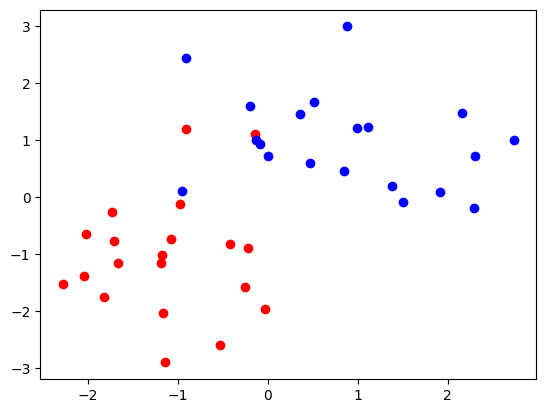

In [15]:
for i in range(40):
    if real_class[i] == -1:
        plt.scatter(X[i][0], X[i][1], c='b')
    else:
        plt.scatter(X[i][0], X[i][1], c='r')

plt.show()

最小平方误差判别有两种实现方式：伪逆法求解和梯度下降法求解。

梯度下降法和上面的感知器实现的类似，只不过迭代公式有变化，就不实现了。梯度下降的实现也叫LMS算法。

下面实现伪逆法：

#### 1. 计算权向量$\boldsymbol{\alpha}$

最小平方误差的判别函数和感知器类似，但是引入了新的常数向量$\mathbf{b}$（这个向量是人为设置的）

如果$\mathbf{b}$把同一类样本的$b_i$设置为相同的值，就和Fisher线性判别等价；

如果$\mathbf{b}$是全为1的向量，最后MSE算法的解是贝叶斯判别函数的最小平方误差逼近，也就是平方误差的期望最小。

判别函数为$g(\mathbf{y}) = \boldsymbol{\alpha}^T\mathbf{y} - \mathbf{b}$

$\boldsymbol{\alpha}$的算法为：

$$\begin{align}\boldsymbol{\alpha} &= \mathbf{Y}^+\mathbf{b} \\ \mathbf{Y}^+&=(\mathbf{Y}^T\mathbf{Y})^{-1}\mathbf{Y}^T\end{align}$$

$\mathbf{Y}^+$也叫$\mathbf{Y}$的伪逆，可以用`np.linalg.pinv()`计算



In [16]:
# 预处理数据和上面感知器是一样的
Y = np.concatenate((np.ones((X.shape[0], 1)), X), 1)

for i in range(20, 40):
    Y[i] = -Y[i]

# 这里我把b设为全1的向量
b = np.ones(Y.shape[0])

alpha = b @ np.linalg.pinv(Y).T
print(alpha)

[-0.06103556 -0.37714435 -0.36073461]


#### 2. 分类

分类和感知器一样，决策规则：

$$若g(\mathbf{y}) = \boldsymbol{\alpha}^T\mathbf{y} \gtrless 0, 则\mathbf{y}\in\begin{cases}\omega_1\\ \omega_2\end{cases}$$

In [17]:
def classify_MSE(_Y: np.ndarray, _alpha: np.ndarray) -> np.ndarray:
    """
    感知机方法分类
    :param _Y: 增广后的样本矩阵（每一行为一个样本），*****注意这里只增广，不改变正负号*****
    :param _alpha: 前面算出的alpha值
    :return: 返回分类好的矩阵（一维向量）
    """
    g = ((_alpha @ _Y.T) >= 0).astype(int)
    for i, g_i in enumerate(g):
        if g_i == 0:
            g[i] = -1
    return g

In [18]:
# 注意我们前面把Y预处理过，把原来的第二类样本y变成了-y，这里要变回来才能分类
ans_MSE = classify_MSE(np.concatenate([Y[:20], -Y[20:]]), alpha)
print("ans_MSE = ")
print(ans_MSE)
print("正确率：", 1 - np.sum(abs(ans_MSE - real_class)) / 2 / X.shape[0])

ans_MSE = 
[-1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
正确率： 0.925


为了证明如果$\mathbf{b}$把同一类样本的$b_i$设置为相同的值，就和Fisher线性判别等价，

我又用Fisher线性分类算了一下结果。显然和MSE完全一致

In [19]:
w = get_w(X[:20], X[20:])
ans_Fisher = classify_Fisher(X, w, get_mean(X[:20]), get_mean(X[20:]))
print("ans_Fisher = ")
print(ans_Fisher)
print("正确率：", 1 - np.sum(abs(ans_Fisher - real_class)) / 2 / X.shape[0])

m_i = 
[-1.12374041 -1.04562119]
S_i = 
[[ 9.11914139  1.19225181]
 [ 1.19225181 20.37591028]]
m_i = 
[0.86006123 0.98289918]
S_i = 
[[21.86960012 -4.99064522]
 [-4.99064522 12.83999022]]
ans_Fisher = 
[-1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
正确率： 0.925


### 四、线性支持向量机

书上在这一章只介绍了思想，没有给出具体的实现算法。

线性支持向量机的思想是：

如果样本是线性可分的，则找出两类样本的分界面，使边界样本到分界面的距离尽可能大。边界样本又叫支持向量。

推广到线性不可分的样本，引入松驰变量$\xi_i \quad i = 1, 2, \cdots, N$

这一节的符号表示和前面不同，用别的教材比较常用的符号来表示。样本向量为$\mathbf{x}_i$，类别为$y_i = 1$或$-1$

线性支持向量机的算法如下

#### 1. 求分类面参数

这个算法的数学推导非常之复杂，书上说了跟没说一样，这篇文章讲的很详细，可以参考一下：[](https://zhuanlan.zhihu.com/p/413953469)

具体算法如下：

(1) 解决最优分类超平面的对偶问题（the dual problem）即通过下面的公式求出$\boldsymbol{\alpha}^*$（具体的求法书中在这章没给出，后面会介绍）

$$\begin{align}
&\max\limits_{\boldsymbol{\alpha}}Q(\boldsymbol{\alpha}) = \sum_{i=1}^{N}\alpha_i - \frac{1}{2}\sum_{i,j=1}^{N}\alpha_i\alpha_jy_iy_j(\mathbf{x}_i\cdot\mathbf{x}_j) \\
&\text{s.t.}\sum_{i=1}^{N}y_i\alpha_i = 0 \\
&0 \leqslant \alpha_i \leqslant C,\quad i=1,\cdots,N
\end{align}
$$

其中$C$是指定常数，强调对分类错误的惩罚。

(2) 通过下面的公式求出$\mathbf{w}^*$

$$\mathbf{w}^* = \sum_{i=1}^N\alpha_i^*y_i\mathbf{x}_i$$

(3)通过下面的公式求出b

$$y_i[(\mathbf{w^*}\cdot\mathbf{x}_i) + b] - 1 + \xi_i = 0$$

需要注意这里的$\mathbf{x}_i, y_i$是一个样本，求b的时候把所有的支持向量样本都用上，每个支持向量算一个b出来，然后算平均值，作为最终的b。

支持向量是$\alpha_i>0$的样本，分为两种：

$0<\alpha_i<C，\xi_i=0$ 的叫边界支持向量（对应分类正确但处在分类边界面上的样本）

$\alpha_i=C， \xi_i>0$ 的叫错分支持向量（对应分类错误的样本）。

### 2. 分类

广义最优分类面的判别函数是：

$$f(\mathbf{x}) = \text{sgn}\{(\mathbf{w}^*\cdot\mathbf{x}) + b\}=\text{sgn}\{\sum_{i=1}^{N}\alpha_i^*y_i(\mathbf{x}_i\cdot\mathbf{x}) + b^*\}$$

### 五、多类线性分类器

#### 1. 多个两类分类器的组合

书中介绍了三种实现方式：$c-1$个一对多、$\frac{c(c-1)}{2}$个逐对分类、$c$个一对多分类器。

注意c个一对多分类器中**不一定**可以直接比较线性判别函数的输出值，用来确定类别。因为$\mathbf{w}$的尺度可能不相同，不同分类器的输出值不一定有可比性

#### 2. 多类线性判别函数

实际上是感知器的变形，也和感知器一样通过迭代来运算。

书中对这个内容介绍篇幅非常少，应该不重要，而且和感知器非常类似，这里就不用代码实现了。